In [18]:
%load_ext autoreload
%autoreload 2
from experiment.experiment import Experiment
from models.tensorflow.monde import Monde
from conf import conf
from models.tensorflow.conf import tf_conf
from experiment.hyper_param_opt import GridSearch
from models.tensorflow.tf_simple_train_eval import TfSimpleTrainEvalModelFactory
from skopt.space import Categorical
from models.tensorflow.utils import get_eval_inputs,get_inputs
from data.data_utils import DataLoader
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.palettes import Category10_5 as colors
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd
from functools import reduce
from copy import copy
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier
import os
# from sklearn.utils.fixes import signature
from scipy import stats
from itertools import combinations
import multiprocessing

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from utils import InMemoryCollector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
conf.num_workers = 1
conf.visible_device_list = []

# MONDE const cov

In [15]:
exp_monde_const_cov = Experiment('classification/fx_3')
exp_monde_const_cov.load(model_name="Monde_const_cov")

In [16]:
y_95_percentile = np.percentile(exp_monde_const_cov.data_loader.train_y, 95,axis=0)
true_label_test = np.any(exp_monde_const_cov.data_loader.test_y > y_95_percentile, axis=1)

In [ ]:
result_test_monde_const_cov = exp_monde_const_cov.predict_best_model({'x':exp_monde_const_cov.data_loader.test_x, 'y':(np.ones(exp_monde_const_cov.data_loader.test_y.shape)*y_95_percentile).astype(np.float32)}, InMemoryCollector())

In [20]:
std_norm_mv_monde_const_cov = stats.multivariate_normal(mean=[0]*exp_monde_const_cov.data_loader.test_y.shape[1], cov=result_test_monde_const_cov['cor'][0])
quantiles_monde_const_cov = [stats.norm.ppf(cdf) for cdf in result_test_monde_const_cov['cdfs']]
test_score_monde_const_cov = 1-std_norm_mv_monde_const_cov.cdf(np.concatenate(quantiles_monde_const_cov, axis=1))

In [21]:
fpr_monde_const_cov, tpr_monde_const_cov, thresholds_monde_const_cov = roc_curve(true_label_test, test_score_monde_const_cov)
roc_auc_monde_const_cov = auc(fpr_monde_const_cov, tpr_monde_const_cov)

In [22]:
precision_monde_const_cov, recall_monde_const_cov, _ = precision_recall_curve(true_label_test, test_score_monde_const_cov)
average_precision_monde_const_cov = average_precision_score(true_label_test, test_score_monde_const_cov)

# MONDE param cov

In [23]:
exp_monde_param_cov = Experiment('classification/fx_3')
exp_monde_param_cov.load(model_name="Monde_param_cov")

In [1]:
result_test_monde_param_cov = exp_monde_param_cov.predict_best_model({'x':exp_monde_param_cov.data_loader.test_x, 'y':(np.ones(exp_monde_param_cov.data_loader.test_y.shape)*y_95_percentile).astype(np.float32)}, InMemoryCollector())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [25]:
quantiles_monde_param_cov = [stats.norm.ppf(cdf) for cdf in result_test_monde_param_cov['cdfs']]
def compute_test_score(row):
    return 1-stats.multivariate_normal.cdf(row[0], mean=[0]*exp_monde_param_cov.data_loader.test_y.shape[1], cov=result_test_monde_param_cov['cor'][row[1]])
pool = multiprocessing.Pool()
test_score_monde_param_cov = np.array(pool.map(compute_test_score, zip(np.concatenate(quantiles_monde_param_cov,axis=1),range(len(quantiles_monde_param_cov[0])))))

In [26]:
fpr_monde_param_cov, tpr_monde_param_cov, thresholds_monde_param_cov = roc_curve(true_label_test, test_score_monde_param_cov)
roc_auc_monde_param_cov = auc(fpr_monde_param_cov, tpr_monde_param_cov)

In [27]:
precision_monde_param_cov, recall_monde_param_cov, _ = precision_recall_curve(true_label_test, test_score_monde_param_cov)
average_precision_monde_param_cov = average_precision_score(true_label_test, test_score_monde_param_cov)

# PUMONDE CL

In [28]:
exp_pumonde_cl = Experiment('classification/fx_3')
exp_pumonde_cl.load(model_name="Pumonde2")

In [2]:
result_test_pumonde_cl = exp_pumonde_cl.predict_best_model({'x':exp_pumonde_cl.data_loader.test_x, 'y':(np.ones(exp_pumonde_cl.data_loader.test_y.shape)*y_95_percentile).astype(np.float32)}, InMemoryCollector())

In [30]:
cdf_pumonde_cl = result_test_pumonde_cl["cdf"]
score_pumonde_cl = 1-cdf_pumonde_cl
fpr_pumonde_cl, tpr_pumonde_cl, thresholds_pumonde_cl = roc_curve(true_label_test, score_pumonde_cl)
roc_auc_pumonde_cl = auc(fpr_pumonde_cl, tpr_pumonde_cl)

In [31]:
precision_pumonde_cl, recall_pumonde_cl, _ = precision_recall_curve(true_label_test, score_pumonde_cl)
average_precision_pumonde_cl = average_precision_score(true_label_test, score_pumonde_cl)

# NN Classifier

In [32]:
exp_nn = Experiment('classification/fx_3')
exp_nn.load(model_name="NNClassifier")

In [3]:
result_test_nn = exp_nn.predict_best_model("test_dict", InMemoryCollector());

In [34]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(true_label_test, result_test_nn["probs"])
roc_auc_nn = auc(fpr_nn, tpr_nn)

In [35]:
precision_nn, recall_nn, _ = precision_recall_curve(true_label_test, result_test_nn["probs"])
average_precision_nn = average_precision_score(true_label_test, result_test_nn["probs"])

# Random Forest

In [36]:
# rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
# # rfc.fit(exp_nn.data_loader.train_x, exp_nn.data_loader.additional_train_data['labels'])

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# param_grid = {'n_estimators':[10,50,100], 'max_depth':[5,10,20]}
# grid_search = GridSearchCV(rfc, param_grid, scoring="roc_auc", n_jobs=2, cv=kfold)
# grid_result = grid_search.fit(np.r_[exp_nn.data_loader.train_x,exp_nn.data_loader.validation_x],  np.r_[exp_nn.data_loader.additional_train_data['labels'],\
#                                                                                                       exp_nn.data_loader.additional_eval_data['labels']])

In [10]:
# grid_search.cv_results_['params'][grid_search.best_index_]

{'max_depth': 20, 'n_estimators': 100}

In [23]:
# tree_predictions_test = grid_search.predict_proba(exp_nn.data_loader.test_x)
# # tree_predictions_test = rfc.predict_proba(exp_nn.data_loader.test_x)
# tree_predictions_test = tree_predictions_test[:,1]

In [24]:
# fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(exp_nn.data_loader.additional_test_data['labels'], tree_predictions_test)
# roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

In [25]:
# precision_rfc, recall_rfc, _ = precision_recall_curve(true_label_test, tree_predictions_test)
# average_precision_rfc = average_precision_score(true_label_test, tree_predictions_test)

In [26]:
# np.save('data/fpr_rfc', fpr_rfc)
# np.save('data/tpr_rfc', tpr_rfc)
# np.save('data/thresholds_rfc', thresholds_rfc)
# np.save('data/roc_auc_rfc', roc_auc_rfc)
# np.save('data/precision_rfc', precision_rfc)
# np.save('data/recall_rfc', recall_rfc)
# np.save('data/average_precision_rfc', average_precision_rfc)

In [37]:
fpr_rfc = np.load('data/fpr_rfc.npy')
tpr_rfc = np.load('data/tpr_rfc.npy')
thresholds_rfc = np.load('data/thresholds_rfc.npy')
roc_auc_rfc = np.load('data/roc_auc_rfc.npy').item()
precision_rfc = np.load('data/precision_rfc.npy')
recall_rfc = np.load('data/recall_rfc.npy')
average_precision_rfc = np.load('data/average_precision_rfc.npy').item()

# XGBoost

In [4]:
# from pandas import read_csv
# from xgboost import XGBClassifier
# import matplotlib
# matplotlib.use('Agg')
# from matplotlib import pyplot
# model_xgb = XGBClassifier()
# subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param_grid = dict(subsample=subsample)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model_xgb, param_grid, scoring="neg_log_loss", n_jobs=2, cv=kfold)
# grid_result = grid_search.fit(np.r_[exp_nn.data_loader.train_x,exp_nn.data_loader.validation_x],  np.r_[exp_nn.data_loader.additional_train_data['labels'],\
#                                                                                                         exp_nn.data_loader.additional_eval_data['labels']])
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [29]:
# xgb_predictions_test = grid_search.predict_proba(exp_nn.data_loader.test_x)
# xgb_predictions_test = xgb_predictions_test[:,1]
# fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(exp_nn.data_loader.additional_test_data['labels'], xgb_predictions_test)
# roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

In [30]:
# precision_xgb, recall_xgb, _ = precision_recall_curve(true_label_test, xgb_predictions_test)
# average_precision_xgb = average_precision_score(true_label_test, xgb_predictions_test)

In [31]:
# np.save('data/fpr_xgb', fpr_xgb)
# np.save('data/tpr_xgb', tpr_xgb)
# np.save('data/thresholds_xgb', thresholds_xgb)
# np.save('data/roc_auc_xgb', roc_auc_xgb)
# np.save('data/precision_xgb', precision_xgb)
# np.save('data/recall_xgb', recall_xgb)
# np.save('data/average_precision_xgb', average_precision_xgb)

In [38]:
fpr_xgb = np.load('data/fpr_xgb.npy')
tpr_xgb = np.load('data/tpr_xgb.npy')
thresholds_xgb = np.load('data/thresholds_xgb.npy')
roc_auc_xgb = np.load('data/roc_auc_xgb.npy').item()
precision_xgb = np.load('data/precision_xgb.npy')
recall_xgb = np.load('data/recall_xgb.npy')
average_precision_xgb = np.load('data/average_precision_xgb.npy').item()

# ROC

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

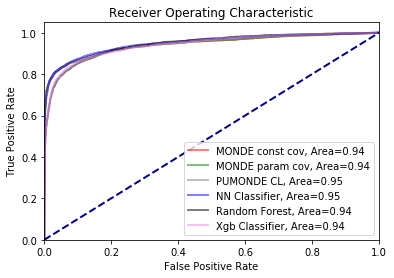

In [42]:
plt.figure()
lw = 2
plt.plot(fpr_monde_const_cov, tpr_monde_const_cov, color='red', lw=lw, label='MONDE const cov, Area={0:0.2f}'.format(roc_auc_monde_const_cov), alpha=0.5)
plt.plot(fpr_monde_param_cov, tpr_monde_param_cov, color='green', lw=lw, label='MONDE param cov, Area={0:0.2f}'.format(roc_auc_monde_param_cov), alpha=0.5)
plt.plot(fpr_pumonde_cl, tpr_pumonde_cl, color='gray', lw=lw, label='PUMONDE CL, Area={0:0.2f}'.format(roc_auc_pumonde_cl), alpha=0.5)
plt.plot(fpr_nn, tpr_nn, color='blue', lw=lw, label='NN Classifier, Area={0:0.2f}'.format(roc_auc_nn), alpha=0.5)
plt.plot(fpr_rfc, tpr_rfc, color='black', lw=lw, label='Random Forest, Area={0:0.2f}'.format(roc_auc_rfc), alpha=0.5)
plt.plot(fpr_xgb, tpr_xgb, color='violet', lw=lw, label='Xgb Classifier, Area={0:0.2f}'.format(roc_auc_xgb), alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.show();
plt.savefig('figures/roc_all_models.png',dpi=1200)

# Precision Recall

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, 'Precision-Recall curve')

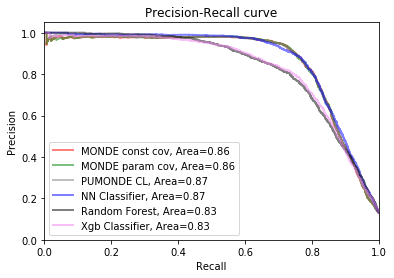

In [43]:
plt.step(recall_monde_const_cov, precision_monde_const_cov, where='post', color='red', lw=lw, label='MONDE const cov, Area={0:0.2f}'.format(average_precision_monde_const_cov), alpha=0.5)
plt.step(recall_monde_param_cov, precision_monde_param_cov, where='post', color='green', lw=lw, label='MONDE param cov, Area={0:0.2f}'.format(average_precision_monde_param_cov), alpha=0.5)
plt.step(recall_pumonde_cl, precision_pumonde_cl, where='post', color='gray', lw=lw, label='PUMONDE CL, Area={0:0.2f}'.format(average_precision_pumonde_cl), alpha=0.5)
plt.step(recall_nn, precision_nn, where='post', color='blue', lw=lw, label='NN Classifier, Area={0:0.2f}'.format(average_precision_nn), alpha=0.5)
plt.step(recall_rfc, precision_rfc, where='post', color='black', lw=lw, label='Random Forest, Area={0:0.2f}'.format(average_precision_rfc), alpha=0.5)
plt.step(recall_xgb, precision_xgb, where='post', color='violet', lw=lw, label='Xgb Classifier, Area={0:0.2f}'.format(average_precision_xgb), alpha=0.5)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
# plt.show();
plt.savefig('figures/pr_all_models.png',dpi=1200)